# GEOG 5160 6160 Lab 02

In this lab, we will introduce the basics of machine learning in Python. We will repeat the example shown in class in which a linear model was built to predict housing prices for a set of individual houses. Before starting the lab, you will need to set up a new folder for your working directory. Go to your `geog5160` folder now and create a new folder for today's class called `lab02`. 

The key package for machine learning in Python is **scikit-learn**. This provides a standard interface managing a machine learning workflow, including setting up training and testing data, running different algorithms and evaluating the models. It is a very mature piece of software having been under continuous development since 2007, and a lot of the approaches and practices are used in other machine learnings packages. 

## Objectives

-   Understand how to set up a basic linear model in Python
-   Use the **scikit-learn** package to design a ML task, a learner and a resampling strategy for validation
-   Explore how to run both regression and classification tasks

**It is highly recommended to use notebooks to store your Python code - this will allow you to easily change and modify it and submit the exercise.**


Let's start by importing the packages that we will need. If you don't have these installed, make sure to do so in a terminal with either
`pip install packagename` or `conda install packagename` depending on your Python setup.

In [65]:
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt

## Data

For today's lab, we will use a data set of house prices from the file *Housing_Price_Data.csv*, which is available through Canvas. The data are taken from a Kaggle dataset [here](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset).

The csv file contains the following columns most of which should be self-explanatory), with values for each California district taken from the 1990 census:

-   `price`: House price in \$'s (possibly not dollars...)
-   `area`: House are in sq ft
-   `bedrooms`: number of bedrooms
-   `bathrooms`: number of bathrooms
-   `stories`: number of stories
-   `mainroad`: On main road (yes/no)
-   `guestroom`: Is there a guestroom? (yes/no)
-   `basement`: Is there a basement? (yes/no)
-   `hotwaterheating`: Is there a hot water heater? (yes/no)
-   `airconditioning`: Is there air conditioning? (yes/no)
-   `parking`: How many parking spots (0-3)
-   `prefarea`: In 'preferred' area (yes/no)
-   `furnishingstatus`: (Furnished/Semi-furnished/Unfurnished)

The goal will be to build a model that can predict the price based on the other variables (or features).

Start by creating a working directory for today's lab (e.g. called 'lab02'), and move the *Housing_Price_Data.csv* to your *datafiles* folder. Next load the data as a Pandas dataframe

In [66]:
df = pd.read_csv("./datafiles/Housing_Price_Data.csv")
df.shape

(545, 13)

In [67]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

Now, use the `head()` method to get an overview of the different variables that are included. 

In [68]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# Linear regression

## Data pre-processing

Before starting building models, we need to check and clean the data. Some things that we may want to check for are:

-   missing values
-   variable conversions
-   outliers


Let's check to see which of the features contain missing values. The following code uses a couple of methods linked together. First `isna()` to check each value in the data frame to see if it is a missing value and flag it as `True` or `False`. Then we use `any()` which returns `True` of `False` for each column if there is at least one `True` (i.e. missing) values in that column:

In [69]:
df.isna().any()

price               False
area                False
bedrooms            False
bathrooms           False
stories             False
mainroad            False
guestroom           False
basement            False
hotwaterheating     False
airconditioning     False
parking             False
prefarea            False
furnishingstatus    False
dtype: bool

For this dataset, there are no missing values (it was cleaned before being put on Kaggle), so we don't need to do anything further here. In the future we'll tackle data with missing values.

### Data transformation

We'll make a few figures to visualize the data before starting. First, a histogram of `price`:

Text(0.5, 0, 'Price ($)')

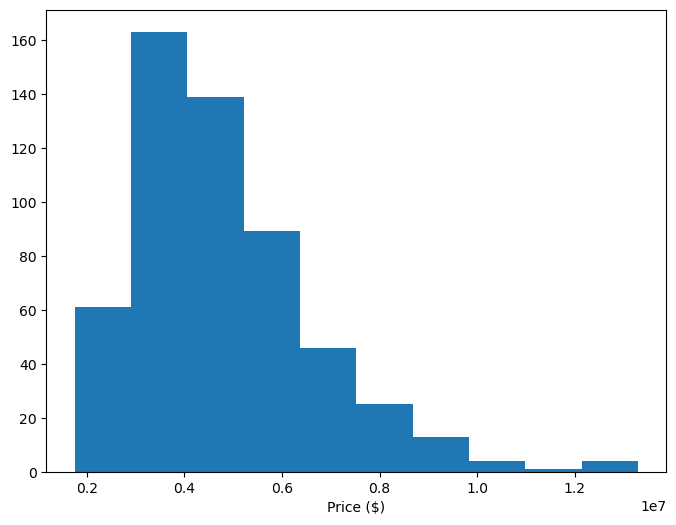

In [70]:
plt.figure(figsize=(8, 6))
plt.hist(df['price'])
plt.xlabel('Price ($)')

Next, the same for `area`:

Text(0.5, 0, 'Area (sq ft.)')

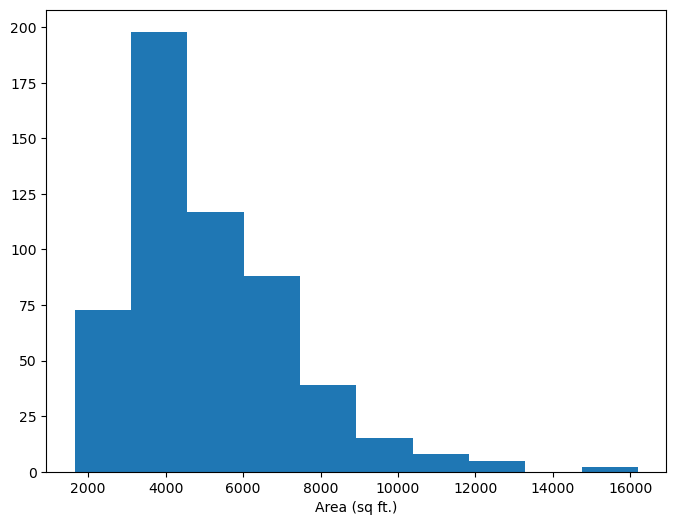

In [71]:
plt.figure(figsize=(8, 6))
plt.hist(df['area'])
plt.xlabel('Area (sq ft.)')

[Optional] We can also get a thorough overview of the data with the **skimpy** package:

In [72]:
from skimpy import skim
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 545    │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 13     │ │ int64       │ 6     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column     ┃ NA  ┃ NA %  ┃ mean     ┃ sd       ┃ p0      ┃ p25     ┃ p50     ┃ p75     ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ price      │   0 │     0 │  4767000 │  1870000 │ 1750000 │ 3430000 │ 4340000 │ 5740000 │ 13300000 │  ▆█▄▁  │  │
│ │ area       │   0 │     0 │     5151 │     2170 │    1650 │    3600 │    4600 │    6360 │    16200 │  █▇▃▁  │  │
│ │ bedrooms   │   0 │     0 │    2.965 │   0.7381 │       1 │       2 │       3 │       3 │        6 │   ▄█▃  │  │
│ │ bathrooms  │   0 │     0 │    1.286 │   0.5025 │       1 │       1 │       1 │       2 │        4 │  █ ▃   │  │
│ │ stories    │   0 │     0 │    1.806 │   0.8675 │       1 │       1 │       2 │       2 │        4 │ █ █ ▁▁ │  │
│ │ parking    │   0 │     0 │   0.6936 │   0.8616 │       0 │       0 │       0 │       1 │        3 │ █ ▃ ▃  │  │
│ └────────────┴─────┴───────┴──────────┴──────────┴─────────┴─────────┴─────────┴─────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per ┃ words per ┃ total      ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ row       ┃ row       ┃ words      ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ mainroad  │  0 │    0 │ no        │ yes       │ no        │ yes       │      2.86 │         1 │        545 │  │
│ │ guestroom │  0 │    0 │ no        │ yes       │ no        │ yes       │      2.18 │         1 │        545 │  │
│ │ basement  │  0 │    0 │ no        │ yes       │ no        │ yes       │      2.35 │         1 │        545 │  │
│ │ hotwaterh │  0 │    0 │ no        │ yes       │ no        │ yes       │      2.05 │         1 │        545 │  │
│ │ eating    │    │      │           │           │           │           │           │           │            │  │
│ │ aircondit │  0 │    0 │ no        │ yes       │ no        │ yes       │      2.32 │         1 │        545 │  │
│ │ ioning    │    │      │           │           │           │           │           │           │            │  │
│ │ prefarea  │  0 │    0 │ no        │ yes       │ no        │ yes       │      2.23 │         1 │        545 │  │
│ │ furnishin │  0 │    0 │ furnished │ semi-furn │ furnished │ unfurnish │      11.7 │         1 │        545 │  │
│ │ gstatus   │    │      │           │ ished     │           │ ed        │           │           │            │  │
│ └───────────┴────┴──────┴───────────┴───────────┴─────

A few things to note here.

-   The `price` and `area` are both right-skewed, and may need transforming to improve our models
-   There are several categorical variables that we will need to one-hot encode

Let's start with transforming the price and area. A standard transformation for right-skewed variables is a log-transformation ($x'=log(x)$):

In [73]:
df['price'] = np.log(df['price'])
df['area'] = np.log(df['area'])

If we now remake the histogram of price, you should see that it has been transformed

Text(0.5, 0, 'Price (log. $)')

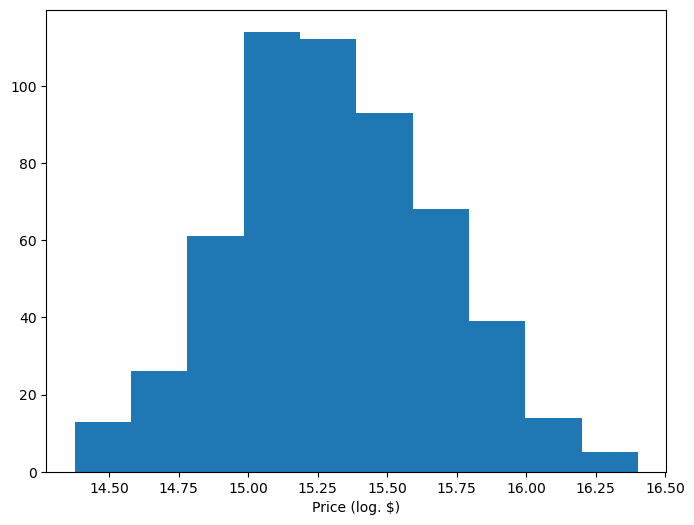

In [74]:
plt.figure(figsize=(8, 6))
plt.hist(df['price'])
plt.xlabel('Price (log. $)')

### One-hot encoding

Now let's one-hot encode the categorical variables. As a reminder, this step allows variables that are recorded as strings (e.g. `yes` or `no`) to simple binary variables (`1` or `0`). Here, we'll use a Pandas function (`get_dummies`) to do this conversion. (One-hot encoded variables are also refered to as dummy variables, hence the name.) To illustrate how this works, we'll demonstrate it first with the `airconditioning` variable, that currently has two values or *levels*:


In [75]:
df['airconditioning'].head()

0    yes
1    yes
2     no
3    yes
4    yes
Name: airconditioning, dtype: object

Now let's encode this using Pandas `get_dummies` function (One-hot encoded variables are also refered to as dummy variables, hence the name). 

In [76]:
pd.get_dummies(df['airconditioning'], dtype='int').head()

,no,yes
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


By default, this returns an encoded variable for each level of `airconditioning`. As one of these is redundant (i.e. when `no` = 1, `yes` must = 0), we can drop the first as follows:

In [77]:
pd.get_dummies(df['airconditioning'],drop_first=True,
               dtype='int').head()

,yes
0,1
1,1
2,0
3,1
4,1


So one-hot encoding should usually return $m-1$ columns, where $m$ is the number of levels. For example, with the furnishing variable that has 3 levels, we get 3-1=2 new columns:

In [78]:
pd.get_dummies(df['furnishingstatus'],drop_first=True,
               dtype='int').head(10)

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
5,1,0
6,1,0
7,0,1
8,0,0
9,0,1


Before proceeding, we'll set up a couple of arrays of feature names to help. One of these will have all the features, and the second the subset that are categorical and need encoding. For some future approaches, it can also be useful to define the numerical features, but that is less important here.

In [79]:
all_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
            'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
            'parking', 'prefarea', 'furnishingstatus']
cat_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 
            'parking', 'prefarea', 'furnishingstatus']

The standard practice in **scikit-learn** is to define two new arrays or data frames, so we'll do that next:

- `X`: which contains all the features
- `y`: which contains the target (`price`)

In [80]:
X = df[all_vars]
y = df['price']

Now we can one-hot encode `X`

In [81]:
X = pd.get_dummies(X, columns=cat_vars, dtype='int', drop_first=True)
X.head()

,area,bedrooms,bathrooms,stories,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,parking_1,parking_2,parking_3,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,8.911934,4,2,3,1,0,0,0,1,0,1,0,1,0,0
1,9.100526,4,4,4,1,0,0,0,1,0,0,1,0,0,0
2,9.206332,3,2,2,1,0,1,0,0,0,1,0,1,1,0
3,8.922658,4,2,2,1,0,1,0,1,0,0,1,1,0,0
4,8.911934,4,1,2,1,1,1,0,1,0,1,0,0,0,0


## **scikit-learn**

We'll now introduce **scikit-learn** by using it to build a simple linear regression model between the median house values and all other variables. **scikit-learn** has a standardized API for running most algorithms, and the steps we are going to take here are largely the same for any of the approaches we will look at over the next couple of weeks (this includes some of the steps above):

- Form a data set of features (or covariates)
- Form a data set of labels (or responses)
- Run any preprocessing
- Split into a *training* and *testing* dataset
- Build or train a model with the training features and labels
- Predict using the testing features
- Compare the predicted test labels to the observed test labels
- Calculate a score indicating the model performance

### Training and testing sets

Next, we'll create a training and testing dataset. There are various approaches to do this, but for now, we'll simply use a holdout method, with 75% of the data in the training set and 25% in testing. **scikit-learn** has a function (`train_test_split`) to help with this. The argument `train_size` controls the size of the training set (here 75%). You can also set this to an integer value, in which case it will random select that number of observations for training. You can also use `test_size` if you'd prefer to control the size of the testing set

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

Let's check the dimensions of our new datasets

In [83]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(408, 15)
(408,)
(137, 15)
(137,)


Giving approximately 400 samples in training and 130 in testing. Note that the `X` arrays have 15 columns representing the features, and the `y` arrays have only 1

### Training a model

We're going to use the linear regression function from **scikit-learn** (`LinearRegression()`). This is one of a set of linear models, so start by loading that module. For any scikit model, we first instantiate the model by calling the function name, then fit the model by (not too surprisingly) calling the `fit` method with the training data 

In [84]:
## Import algorithm
from sklearn.linear_model import LinearRegression
## Instantiate
lr = LinearRegression()
## Train (fit)
lr.fit(X_train, y_train)

LinearRegression()

Having fit the model, we can check the results. First, we'll make a table of the regression coefficients:

In [85]:
print(lr.coef_)

[ 0.29821646  0.02046452  0.18820125  0.07910391  0.08445265  0.04101375
  0.10217637  0.12434957  0.13797065  0.0401125   0.08453053  0.02989092
  0.13169543 -0.01279195 -0.11331517]


As this is just an array of coefficients, we can make this into a table to show the corresponding features:

In [86]:
cdf = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coefficients'])
print(cdf)

                                 Coefficients
area                                 0.298216
bedrooms                             0.020465
bathrooms                            0.188201
stories                              0.079104
mainroad_yes                         0.084453
guestroom_yes                        0.041014
basement_yes                         0.102176
hotwaterheating_yes                  0.124350
airconditioning_yes                  0.137971
parking_1                            0.040113
parking_2                            0.084531
parking_3                            0.029891
prefarea_yes                         0.131695
furnishingstatus_semi-furnished     -0.012792
furnishingstatus_unfurnished        -0.113315


This output gives the coefficients (the slope values) for each of the variables used. Most of these are straightforward to interpret (e.g. house price increases with the number of bedrooms), but others are less straightforward (e.g. the furnishing status variables). In addition, the `R-squared` value here is pretty decent ($\approx 0.7$), which suggests this explains the outcome well. Note that this is an indication of how well the model has been trained with the data, not how well it will predict for a new house. Note that the coefficients do not include the intercept, so to show this:

In [87]:
print(lr.intercept_)

12.161507061472118


The `score()` method will return the coefficient of determination ($R^2$), which suggests this explains the outcome well (closer to 1 is better). Note that this is an indication of how well the model has been trained with the data, not how well it will predict for a new house.

In [88]:
print(lr.score(X_train, y_train))

0.7147141814668403


### Predicting with the test set

Next step is to predict the labels or outcomes for the testing set. As a reminder, these are data that were *not* used to train the model, but where the target (`price`) is known.

Prediction in **scikit-learn** is pretty straightforward, we simply call the `predict()` method on our trained model, and pass the `X_test` DataFrame.

In [89]:
y_test_pred = lr.predict(X_test)

Now we can plot the predicted house values against the observed value.

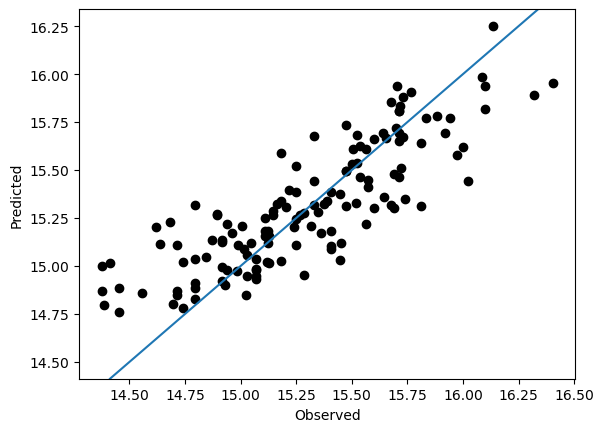

In [90]:
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.axline((14.5, 14.5), slope=1., color='C0', label='by slope')
plt.show()

What we hope to see from this plot is that there is relatively little scatter in the points, and that they follow the 1:1 line. You should likely see a little bias in the tails (very low or high prices), which is a common issue with any predictive model.

In addition to this visualization, we also need to quantify this using a performance score. This will eventually allow us to compare different learning algorithms or different setups of the same algorithm to see which is best. Not too surprisingly then, **scikit** comes with a whole suite of different metrics that we can use. To see the full list, go here: https://scikit-learn.org/stable/modules/model_evaluation.html

Here, we'll calculate:

-   The $R^2$ (the proportion of variation in the test set prices that was captured)
-   The root mean squared error (the average prediction error)

$$
RMSE = \sqrt{\sum_i{(\hat{y_i} - y_i})^2}
$$


We'll calculate these metrics here using the predictions for the test set:

In [91]:
from sklearn.metrics import root_mean_squared_error, r2_score

print(f"RMSE: {root_mean_squared_error(y_test, y_test_pred)}")
print(f"R2: {r2_score(y_test, y_test_pred)}")

RMSE: 0.24053492539466909
R2: 0.6906961545614778


In addition, we'll caclulate the bias of the model as $1/n \times \sum_i (\hat{y}_i - y_i)$. Bias lets you know if there is systematic under or over estimation in the model (ideally this should be close to 0). 

In [92]:
bias = np.mean(y_test_pred - y_test)
print(f"Bias: {bias}")

Bias: 0.020317588432252842


## Cross-validation with **scikit-learn**

So far, we have built and tested our model on a single split of the data (the hold-out method). However, if the training and testing datasets are not well set up, the estimates of model performance can be biased. There are several more exhaustive resampling strategies that can be used instead, and we will implement one of these now. This link provides a list of available strategies: https://scikit-learn.org/stable/modules/cross_validation.html

More commonly, $k$-fold cross-validation is used, which repeats the hold-out $k$ times. Each time $1/$k$ of the samples are added to the testing set and the remaining samples in the training set. We'll use a 4-fold cross-validation here (this is usually in the range of 3-10). The function `KFold` allows us to set this up, which takes an argument to set the number of folds (`n_splits`), and one to shuffle the data to make sure that the samples are well distributed between training and testing.



In [93]:
from sklearn.model_selection import KFold, cross_val_score

n_splits=4
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

The set of folds are then used to estimate performance scores using the function `cross_val_score`. This needs the following argument:
 
 - The algorithm we are using (this is the instantiated model, `lr`)
 - The set of features (`X`). Note that this is the full dataset, as the cross-validation will take of splitting into training and testing
 - The targets (`y`)
 - The cross-validation strategy defined in the previous function (`cv`)
 - The performance metric. Note that this uses the negative RMSE. This might seem a little odd, but will become more clear when we introduce tuning

In [94]:
scores = cross_val_score(lr, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

We can now print out the set of cross-validated scores and calculate the mean RMSE (we add a `-` to make these non-negative)

In [95]:
with np.printoptions(precision=3, suppress=True):
    print(-scores)
print("%.3f" % np.mean(-scores))

[0.241 0.201 0.17  0.215]
0.207


And we can re-run this to get the average prediction R2 as well:

In [96]:
scores = cross_val_score(lr, X, y, cv=cv, scoring = 'r2')
print("%.3f" % np.mean(scores))

0.685


## Changing model

We're going to be looking a wide range of different algorithms for machine learning over the next few weeks. This section is just designed to show how easy it is to switch out the method you are using to try a different approach. Here, we'll try using a penalized linear model, the Lasso. To test this, we simply need to import the relevant module from `sklearn.linear_model`, instantiate and run the same cross-validation strategy we previously defined. In this case, there is little improvement with this new algorithm. 

This model has a hyperparameter (`alpha`), which is used to set the amount of the penalty weight (confusingly, this is referred to as $\lambda$ in most descriptions of the model)


In [97]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)
scores = cross_val_score(lasso_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))
#print(lasso_reg.alpha_)

0.206


In this case, there is little improvement with this new algorithm, but hopefully this demonstrates how easy it is to add and test additional algorithms with **scikit-learn**

# Logistic regression

## Model setup

We'll quickly look at an example of working with a classification exercise using the same dataset. We'll create a new binary variable defined as simply whether or not a house has a high or low price (is the price above 5.5 million or not). To do this, we first a binary outcome (`y_bin`) based on whether the values are above the threshold (note that the prices are log-transformed, we need to use the log of 5.5 million)

In [98]:
y_bin = (y > np.log(5.5e6)).astype(int)
y_bin

0      1
1      1
2      1
3      1
4      1
      ..
540    0
541    0
542    0
543    0
544    0
Name: price, Length: 545, dtype: int64

Next, load and instantiate a logistic regression model

In [99]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(penalty=None)

Make a new $k$-fold corss-validation. Here, we'll use `StratifiedKFold`. This ensures that the balance between `0`s and `1`s is approximately the same in all folds. This is particularly important if there are lot more in one or the other class. 

In [100]:
from sklearn.model_selection import StratifiedKFold
n_splits=4
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Finall, we'll run the cross-validation using the new target, model and training/test folds. We'll use a different function here (`cross_validate`), as this allows use to calculate several performance metrics in one go. We'll calculate:

-   The accuracy (the number of correctly predicted `low` and `high` house prices)
-   The precision (the number of predicted `high` house prices that are correct)
-   The recall or sensitivity (the number of `high` house prices that are correctly predicted)
-   The specificity (the number of `low` house prices that are correctly predicted)

The specificity is a little more difficult as there is no default function, but we can create one fairly simply:

In [101]:
from sklearn.metrics import make_scorer, recall_score

specificity = make_scorer(recall_score, pos_label=0)

In [102]:
from sklearn.model_selection import cross_validate
scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro',
           'specificity': specificity}

scores = cross_validate(logr, X, y_bin, cv=cv, scoring = scoring)

/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/geog5160/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

You may get warnings about the number of iterations. This generally means that the model is struggling with correlations between variables. We'll ignore it for the purposes of this lab, but it is something that would need further investigation. Now we can access any of the performance metrics from these results (e.g. the accuracy):

In [103]:
scores

{'fit_time': array([0.00619507, 0.00473905, 0.01712894, 0.00465393]),
 'score_time': array([0.00286889, 0.00240278, 0.0029912 , 0.00314593]),
 'test_accuracy': array([0.88321168, 0.875     , 0.86029412, 0.86764706]),
 'test_precision': array([0.85601504, 0.85277778, 0.83823529, 0.84554455]),
 'test_recall': array([0.86610825, 0.8357124 , 0.81007137, 0.82289188]),
 'test_specificity': array([0.90721649, 0.92783505, 0.92783505, 0.92783505])}

In [104]:
scores['test_accuracy']

array([0.88321168, 0.875     , 0.86029412, 0.86764706])

And we can get the average values

In [105]:
print(f"Accuracy: mean {np.mean(scores['test_accuracy'])}, sd: {np.std(scores['test_accuracy'])}")
print(f"Precision: mean {np.mean(scores['test_precision'])}, sd: {np.std(scores['test_precision'])}")
print(f"Recall: mean {np.mean(scores['test_recall'])}, sd: {np.std(scores['test_recall'])}")
print(f"Specificity: mean {np.mean(scores['test_specificity'])}, sd: {np.std(scores['test_specificity'])}")

Accuracy: mean 0.8715382138256763, sd: 0.008512116876812453
Precision: mean 0.8481431659862138, sd: 0.006862300924608275
Recall: mean 0.8336959754163362, sd: 0.020793458106534726
Specificity: mean 0.9226804123711341, sd: 0.008928096946231343


## Exercise

Use a new notebook to record your answers and output. These should be submitted to Canvas. Please use the following naming convention: `Lab02_lastname.ipynb`.

The goal of the exercise is to get you to build and evaluate the *area* of a house, rather than the price. A few things to note:

-   The `price` needs to be included as a feature
-   You still need to log-transform and encode variables
-   Your model should be evaluated using 4-fold cross-validation, and you should report the RMSE and $R^2$


## 6160 Students

In addition to the above exercise, you should build and evaluate a second logistic regression model for houses with high or low area.

-   Use a cutoff of 10,000 sq ft. (higher should be labeled as `high`)
-   Use 4-fold cross-validation
-   Report the accuracy, recall and specificity
-   Optional: why do you think there is such a large difference between recall and specificity in this model?